<a href="https://colab.research.google.com/github/karasu1982/AutoML_Regression/blob/main/AutoML_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 環境設定

In [ ]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install autogluon==0.5.0

In [ ]:
!pip install ephem
!pip install pystan
!pip install prophet

In [97]:
!pip install salesforce-merlion

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.9/565.9 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.7 MB/s eta 0:00:00


In [56]:
# 標準ライブラリ
import pandas as pd
import numpy as np

# 分析用ライブラリ
from sklearn.model_selection import train_test_split

# データ見える化
import seaborn as sns
import matplotlib.pyplot as plt

# データ準備・加工

## データ準備

ID-POSのサンプルデータとして、下記を利用

https://www.kyoritsu-pub.co.jp/book/b10003634.html

In [ ]:
!wget https://kyoritsu-pub.sakura.ne.jp/app/file/goods_contents/2319.zip
!unzip /content/2319.zip
!unzip /content/DataProcess.20151001/src/data/Tafeng/Tafeng.zip

In [27]:
df = pd.read_csv("/content/Tafeng_dataset/Tafeng.csv")

In [29]:
df.head(3)

,Time,CustID,Age,Area,ProductSubClass,ProductID,Amount,Asset,SalesPrice
0,2000-11-01 00:00:00,46855,D,E,110411,4710085120468,3,51,57
1,2000-11-01 00:00:00,539166,E,E,130315,4714981010038,2,56,48
2,2000-11-01 00:00:00,663373,F,E,110217,4710265847666,1,180,135


## データ加工

In [35]:
# 日別の集計データ
df1 = df[['Time','SalesPrice']].groupby('Time').sum()
df1 = df1.reset_index() # TimeをIndexではなく、項目化

In [44]:
df1["Time"] = pd.to_datetime(df1.Time, format="%Y-%m-%d")

In [47]:
# 曜日を日付から取得して、OneHotEncoding
df1["DayOfWeek"] = df1["Time"].dt.day_name()
df1 = pd.get_dummies(df1, columns=["DayOfWeek"])

# 月を日付から取得
df1["Month"] = df1["Time"].dt.month

In [ ]:
df1

In [103]:
# 期間で訓練データとテストデータに分割

df_train = df1[(df1["Time"] <= "2000-12-31")]
df_test = df1[(df1["Time"] >= "2001-01-01")]

# AutoGluon

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [53]:
# 予測実施
predictor = TabularPredictor(label='SalesPrice').fit(df_train, time_limit=600)

Level 25:autogluon.common.utils.utils:No path specified. Models will be saved in: "AutogluonModels/ag-20221030_052719/"
INFO:autogluon.tabular.learner.default_learner:Beginning AutoGluon training ... Time limit = 600s
INFO:autogluon.tabular.learner.default_learner:AutoGluon will save models to "AutogluonModels/ag-20221030_052719/"
INFO:autogluon.tabular.learner.default_learner:AutoGluon Version:  0.5.0
INFO:autogluon.tabular.learner.default_learner:Python Version:     3.7.15
INFO:autogluon.tabular.learner.default_learner:Operating System:   Linux
INFO:autogluon.tabular.learner.default_learner:Train Data Rows:    61
INFO:autogluon.tabular.learner.default_learner:Train Data Columns: 9
INFO:autogluon.tabular.learner.default_learner:Label Column: SalesPrice
INFO:autogluon.tabular.learner.default_learner:Preprocessing data ...
Level 25:autogluon.core.utils.utils:AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values obser

In [54]:
# 予測結果
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model      score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2 -231314.073542       0.108683  1.111207                0.001046           0.352059            2       True         12
1       RandomForestMSE -236115.358980       0.102767  0.395413                0.102767           0.395413            1       True          5
2         ExtraTreesMSE -249655.999883       0.102700  0.400134                0.102700           0.400134            1       True          7
3         LightGBMLarge -251881.533781       0.002260  0.170368                0.002260           0.170368            1       True         11
4       NeuralNetFastAI -282140.027216       0.010459  2.866654                0.010459           2.866654            1       True          8
5        NeuralNetTorch -305911.560773       0.006748  0.447918                0.00674

{'model_types': {'KNeighborsUnif': 'KNNModel',
  'KNeighborsDist': 'KNNModel',
  'LightGBMXT': 'LGBModel',
  'LightGBM': 'LGBModel',
  'RandomForestMSE': 'RFModel',
  'CatBoost': 'CatBoostModel',
  'ExtraTreesMSE': 'XTModel',
  'NeuralNetFastAI': 'NNFastAiTabularModel',
  'XGBoost': 'XGBoostModel',
  'NeuralNetTorch': 'TabularNeuralNetTorchModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif': -565072.490784473,
  'KNeighborsDist': -539735.7873226466,
  'LightGBMXT': -319998.3286885607,
  'LightGBM': -345737.37055104144,
  'RandomForestMSE': -236115.35897981026,
  'CatBoost': -334563.05405218515,
  'ExtraTreesMSE': -249655.9998834732,
  'NeuralNetFastAI': -282140.0272163021,
  'XGBoost': -306142.4002403183,
  'NeuralNetTorch': -305911.5607725155,
  'LightGBMLarge': -251881.53378130603,
  'WeightedEnsemble_L2': -231314.0735420259},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'KNeighborsUnif': 'Autoglu

In [ ]:
# 予測モデル適用

df_total = df1.copy()

df_actual = df_total.pop("SalesPrice")
df_predict = predictor.predict(df_total)

In [58]:
# 予測結果見える化
# 統計値

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("MSE:{}".format(mean_squared_error(df_actual, df_predict)))
print("決定係数:{}".format(r2_score(df_actual, df_predict)))

MSE:245839241992.66925
決定係数:0.09471253898862153


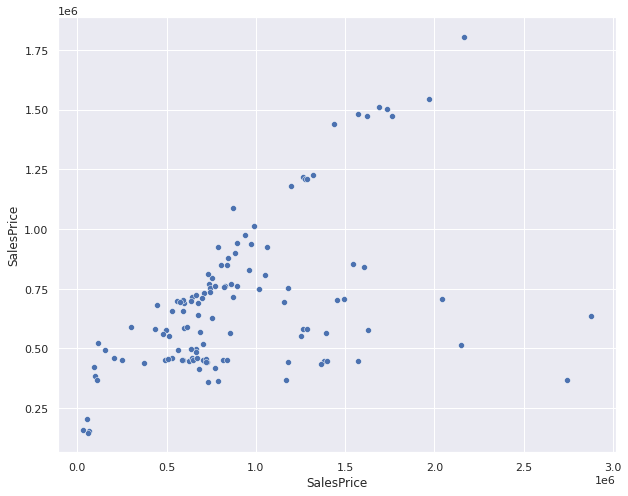

In [57]:
# 予測結果見える化
# 散布図

plt.figure(figsize=(10, 8))
sns.set(style="darkgrid")
ax = sns.scatterplot(x=df_actual,y=df_predict)

# Prophet

In [ ]:
from prophet import Prophet

In [75]:
# Prophet用にデータ加工

df_train = df_train.rename(columns={'SalesPrice': 'y','Time': 'ds'})
df_test = df_test.rename(columns={'SalesPrice': 'y','Time': 'ds'})

In [77]:
# CAPつけるための、過去最大金額
df["SalesPrice"].max()

444000

In [81]:
# 予測実施
model = Prophet(growth='logistic', daily_seasonality=False)
model.add_country_holidays(country_name="JP")
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# 予測に追加する変数
features_list =["Month","DayOfWeek_Friday","DayOfWeek_Monday","DayOfWeek_Saturday","DayOfWeek_Sunday","DayOfWeek_Thursday","DayOfWeek_Tuesday","DayOfWeek_Wednesday"]

for f in features_list:
  model.add_regressor(f)

df_train['cap']=500000 #非線形の場合はCAP必須

model.fit(df_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiamyn8gk/7bs53g08.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiamyn8gk/4dds9hk8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68898', 'data', 'file=/tmp/tmpiamyn8gk/7bs53g08.json', 'init=/tmp/tmpiamyn8gk/4dds9hk8.json', 'output', 'file=/tmp/tmpiamyn8gk/prophet_modelp4x6a_0_/prophet_model-20221030055618.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:56:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:56:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [88]:
future = model.make_future_dataframe(periods=30, freq='D')
future["cap"]=500000
future=pd.merge(future, df_test, on="ds")

df_forecast = model.predict(future)

In [96]:
df_forecast.head(3)

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,DayOfWeek_Friday,DayOfWeek_Friday_lower,DayOfWeek_Friday_upper,...,海の日,海の日_lower,海の日_upper,秋分の日,秋分の日_lower,秋分の日_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2001-01-01,499790.184509,500000,5.406454e+06,5.990532e+06,499790.184509,499790.184509,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.697760e+06
1,2001-01-02,499823.112121,500000,5.591074e+06,6.178879e+06,499823.112121,499823.112121,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.887750e+06
2,2001-01-03,499850.873746,500000,5.678651e+06,6.263560e+06,499850.873746,499850.873746,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.963691e+06


In [ ]:
# forecastとactualをマージ

df_output=pd.merge(df_forecast, df_test, on="ds")

gap_abs = 0
gap_all = 0

for index, row in df_output.iterrows():
  gap_abs = gap_abs + abs(row["yhat"] - row["y"])
  gap_all = gap_all+ (row["yhat"] - row["y"])

print(gap_abs)
print(gap_all)

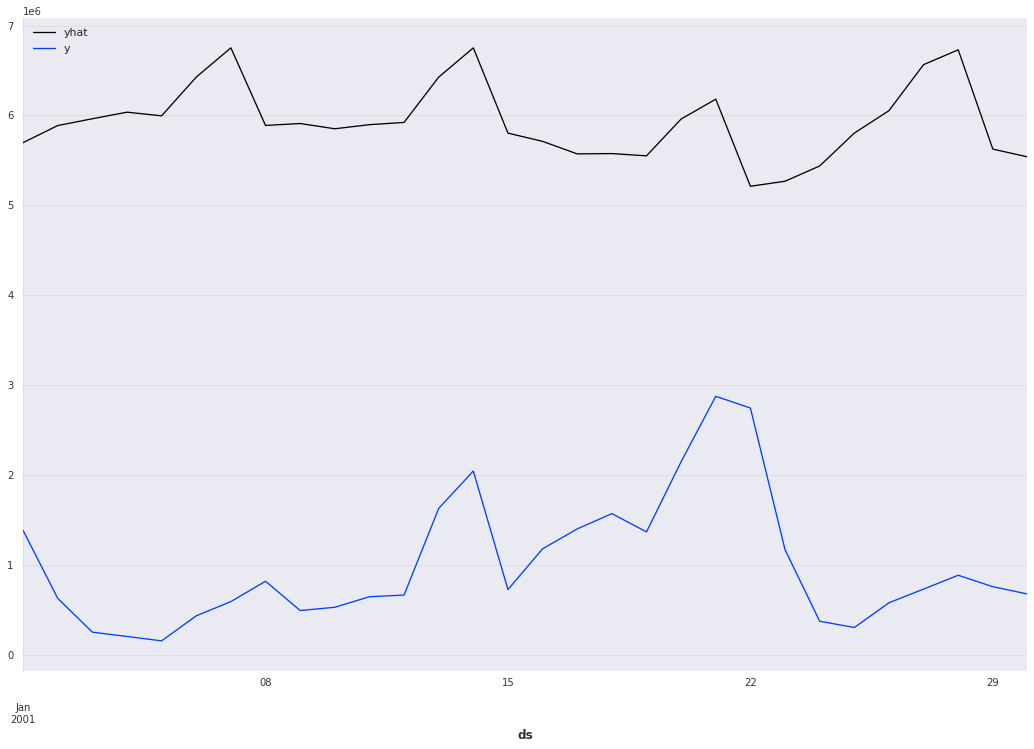

In [95]:
pd.plotting.register_matplotlib_converters()
df_output.plot(figsize=(18, 12), x="ds", y=["yhat","y"])

# Merlion


In [98]:
from merlion.utils import TimeSeries
from merlion.models.defaults import DefaultForecasterConfig, DefaultForecaster

In [113]:
# Merlion用にデータ加工

train_ts = TimeSeries.from_pd(df_train[["Time","SalesPrice"]].set_index("Time"))
val_ts = TimeSeries.from_pd(df_test[["Time","SalesPrice"]].set_index("Time"))

In [114]:
train_ts

            SalesPrice
time                  
2000-11-01     96614.0
2000-11-02    892411.0
2000-11-03    963306.0
2000-11-04   1264999.0
2000-11-05   1763728.0
...                ...
2000-12-27   1020150.0
2000-12-28    870346.0
2000-12-29    448086.0
2000-12-30    769653.0
2000-12-31   1543617.0

[61 rows x 1 columns]

In [ ]:
# 予測実施

## DefaultForecasterモデルのセット
model = DefaultForecaster(DefaultForecasterConfig())
model.train(train_data=train_ts)

In [115]:
# 予測モデル適用
test_pred, test_err = model.forecast(time_stamps=val_ts.time_stamps)

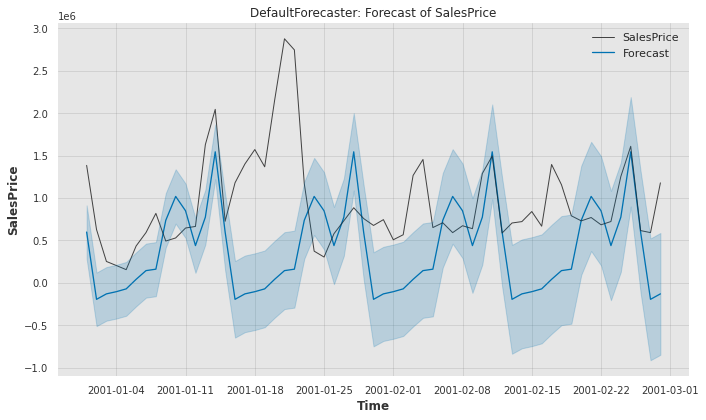

In [116]:
fig, ax = model.plot_forecast(time_series=val_ts, plot_forecast_uncertainty=True)
# 表示
plt.show()